# **Comments**

This notebook is to design a model, replacing the old scoring function about the structure module, using **RNN** type neural networks.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data

import numpy as np
import os
import collections
from datetime import datetime
import time

from sklearn.model_selection import KFold
from d2l import torch as d2l

## **Define some assistants**

Timer for calculating the time cost in some cells.

try_gpu for determination of the running device.

Accumulator for the summation of the numbers in the training process.

In [2]:
class Timer:
    """Record multiple running times."""
    def __init__(self):
        """Defined in :numref:`sec_minibatch_sgd`"""
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()


In [3]:
def try_gpu(i=0):
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [4]:
class Accumulator:
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

## **Data preparation**

First of all, let's make a vocabulary.

In [5]:
class Vocab:
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        
        counter = counter_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}
        
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1
    
    def __len__(self):
        return len(self.idx_to_token)
    
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]
    
    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]
    
    @property
    def unk(self):
        return 0
    
    @property
    def token_freqs(self):
        return self._token_freqs
        
        
def counter_corpus(tokens):
    if len(tokens) == 0 or isinstance(tokens[0], list):
        tokens = [token for line in tokens for token in line]
    
    return collections.Counter(tokens)

In [6]:
def read_sequence(directory, file):
    with open(os.path.join(directory, file), 'r') as f:
        return f.readlines()
    
def tokenize(lines):
    alltoken = []
    # 读取这个文件，并将数字和seqeunce内容分开
    for line in lines:
        if list(line)[0] == '#':
            continue
        else:
            alltoken.append(line.strip().split())
    return alltoken

In [7]:
#test
# directory = '../data/'
# file = 'student_train.log'
# lines = read_sequence(directory, file)
# tokens = tokenize(lines) # 第一列为lossscore，第二列为sequence

# digits = torch.tensor([float(d) for d in np.array(tokens)[:, 0]], dtype = torch.float32) 
# tokens = [list(_) for _ in np.array(tokens)[:, 1]]
# vocab = Vocab(tokens)
# vocab['P']

In [8]:
def load_seq(batch_size, is_train=False, directory='../data', file='All_loss_databank.log', max_tokens=-1, device=try_gpu()):
    lines = read_sequence(directory, file)
    tokens = tokenize(lines)
    digits = torch.tensor([float(d) for d in np.array(tokens)[:, 0]], dtype=torch.float32).unsqueeze(1).to(device)
    tokens = [list(_) for _ in np.array(tokens)[:, 1]]
    vocab = Vocab(tokens)
    corpus = torch.tensor([[vocab[token] for token in line]for line in tokens], dtype=torch.long).to(device)
    
    if max_tokens > 0:
        corpus = corpus[:max_tokens]

    num_batches = len(digits) // batch_size

    # Construct dataset
    # if you want: y_scale = log(y + 1e-9)
    # dataset = (corpus[:num_batches * batch_size], torch.log(digits[:num_batches * batch_size] + 1e-9))
    dataset = (corpus[:num_batches * batch_size], digits[:num_batches * batch_size] + 1e-9)
    dataset = data.TensorDataset(*dataset)
    data_iter = data.DataLoader(dataset, batch_size, shuffle=is_train)

    return data_iter, vocab


In [9]:
timer = Timer()
timer.start()
batch_size = 256
train_iter, vocab = load_seq(batch_size, is_train = True, directory='../data', file='student_train.log')
timer.stop()
print(timer.sum())
#test
# for x, y in train_iter:
#     print(x,y)
#     break

1.6136236190795898


## **Model**

In [10]:
class PositionWiseFFN(nn.Module):
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs):
        super(PositionWiseFFN, self).__init__()
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)
        
    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

class RNNModel(nn.Module):
    def __init__(self, rnn_layer, vocab_size, ffn_num_hiddens, 
                 linear1_num_hiddens, linear2_num_hiddens, linear3_num_hiddens,
                 dropout, **kwargs):
        
        super(RNNModel, self).__init__()
        self.vocab_size = vocab_size
        self.rnn = rnn_layer
        self.num_hiddens = self.rnn.hidden_size
        self.relu = nn.ReLU()
        
        self.ffn = PositionWiseFFN(self.num_hiddens, ffn_num_hiddens, self.num_hiddens)
        self.dropout = nn.Dropout(dropout)
        
        self.linear1 = nn.Linear(self.num_hiddens, linear1_num_hiddens)
        
        self.bn = nn.BatchNorm2d(linear1_num_hiddens)
        self.linear2 = nn.Linear(linear1_num_hiddens,linear2_num_hiddens)
        self.linear3 = nn.Linear(linear2_num_hiddens,linear3_num_hiddens)
        self.output = nn.Linear(linear3_num_hiddens,1)
    
    def forward(self, inputs, state):
        # inputs --> (batch_size, num_steps)
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        # X --> (num_steps, batch_size, features)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # Y --> (num_steps, batch_size, hidden_size)
        Y = Y.permute(1, 0, 2)
        # Y --> (batch_size, num_steps, hidden_size)
        Y = Y.sum(dim = 1) #在num_steps维度上合并
        
        output = self.linear1(self.dropout(self.ffn(Y))+Y).unsqueeze(2).unsqueeze(3)
        output = self.linear2(self.relu(self.bn(output).squeeze(3).squeeze(2)))
        output = self.output(self.relu(self.linear3(output)))
        
        return output, state
    
    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # GRU & RNN
            return torch.zeros((self.rnn.num_layers, 
                                batch_size, self.num_hiddens), device = device)
        
        else:
            # LSTM
            return (torch.zeros((
                self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

In [ ]:
num_hiddens, num_layers = 64, 1

directory = '../datanet/'
file = 'student_train.log' 
lines = read_sequence(directory, file)
tokens = tokenize(lines)
tokens = [list(_) for _ in np.array(tokens)[:, 1]]
vocab = Vocab(tokens)

#len(vocab) = 21
rnn_layer = nn.RNN(len(vocab), num_hiddens, num_layers)
ffn_num_hiddens, linear1_num_hiddens, linear2_num_hiddens, linear3_num_hiddens = 32, 32, 32, 8

net = RNNModel(rnn_layer, len(vocab), ffn_num_hiddens, 
               linear1_num_hiddens, linear2_num_hiddens, linear3_num_hiddens, dropout=0.5)


In [12]:
net

RNNModel(
  (rnn): RNN(21, 64)
  (relu): ReLU()
  (ffn): PositionWiseFFN(
    (dense1): Linear(in_features=64, out_features=32, bias=True)
    (relu): ReLU()
    (dense2): Linear(in_features=32, out_features=64, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (linear1): Linear(in_features=64, out_features=32, bias=True)
  (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=32, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=8, bias=True)
  (output): Linear(in_features=8, out_features=1, bias=True)
)

# Training

In [13]:
#初始化参数
def xavier_init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.GRU or type(m) == nn.LSTM:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])
                
def grad_clipping(net, theta):
    """裁剪梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

def predict_test(net, test_iter, loss, device):
    net.eval()
    with torch.no_grad():
        for test_x, test_y in test_iter:
            test_x = test_x.to(device)
            test_y = test_y.to(device)
            state = net.begin_state(batch_size=len(test_y), device = device)
            y_hat, _ = net(test_x, state)
            break
        return loss(y_hat, test_y)


def train_epoch(net, train_iter, loss, updater, device, batch_size):
    """训练网络一个迭代周期"""
    net.train()
    state = None
    matric = Accumulator(2) # 损失总数， 样本总数
    for i, (X, Y) in enumerate(train_iter):
        state = net.begin_state(batch_size=X.shape[0], device=device)   
        
        X, y = X.to(device), Y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y)
        updater.zero_grad()
        l.backward()
        grad_clipping(net, 1) #裁剪梯度
        updater.step()
        with torch.no_grad():
            matric.add(l * X.shape[0], X.shape[0])
    return matric[0]/matric[1] #返回loss


def train_rnn_kfold(net, full_train_iter, num_folds, lr, num_epochs, device, batch_size):

    net.apply(xavier_init_weights)
    loss = nn.MSELoss()

    # K-fold similar approach but not the exact KFold in scikit-learn
    # dataset_size = len(full_train_iter.dataset)
    # fold_size = dataset_size // num_folds

    # # Split the dataset into folds
    # indices = np.arange(dataset_size)
    # np.random.shuffle(indices)
    # folds = [indices[i:i + fold_size] for i in range(0, dataset_size, fold_size)]
    # if len(folds) > 1 and len(folds[-1]) < fold_size:
    #     # Merge the last fold into the second-to-last fold
    #     folds[-2].extend(folds[-1])
    #     # Remove the last fold
    #     folds.pop()
    
    # fold_results = []  # List to store results for each fold

    # for fold, test_indices in enumerate(folds):
    #     print(f"FOLD {fold + 1}")
    #     print("--------------------------------")

    #     # Determine the indices for the train set
    #     train_indices = np.setdiff1d(indices, test_indices)

    #     # Create data samplers and loaders for train and test sets
    #     train_subsampler = torch.utils.data.SubsetRandomSampler(train_indices)
    #     test_subsampler = torch.utils.data.SubsetRandomSampler(test_indices)

    #     train_iter = torch.utils.data.DataLoader(full_train_iter.dataset, batch_size=batch_size, sampler=train_subsampler)
    #     test_iter = torch.utils.data.DataLoader(full_train_iter.dataset, batch_size=batch_size, sampler=test_subsampler)

    dataset_size = len(full_train_iter.dataset)

    kfold = KFold(n_splits=num_folds, shuffle=True)
    fold_results = []  # List to store results for each fold
    
    for fold, (train_indices, test_indices) in enumerate(kfold.split(range(dataset_size))):
        print(f"FOLD {fold + 1}")
        print("--------------------------------")
    
        # Create data loaders for train and test sets
        train_iter = torch.utils.data.DataLoader(full_train_iter.dataset, batch_size=batch_size, sampler=torch.utils.data.SubsetRandomSampler(train_indices))
        test_iter = torch.utils.data.DataLoader(full_train_iter.dataset, batch_size=batch_size, sampler=torch.utils.data.SubsetRandomSampler(test_indices))
        
        # Initialize network and optimizer for each fold
        net.to(device)
        updater = torch.optim.Adam(net.parameters(), lr, weight_decay=0.0001)

        animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=['train loss', 'test loss'])
        timer = Timer()

        for epoch in range(num_epochs):
            timer.start()
            l = train_epoch(net, train_iter, loss, updater, device, batch_size)
            test_l = predict_test(net, test_iter, loss, device)
            timer.stop()
            animator.add(epoch + 1, (l, test_l.detach().to('cpu')))

        # Store results for the fold
        fold_results.append((fold, epoch + 1, l, test_l, timer.sum()))

    # Print results for all folds
    for fold, epoch, l, test_l, total_time in fold_results:
        print(f"Fold {fold+1}, epoch {epoch}, loss {l:f}, test loss {test_l:f}, {epoch/total_time:f} epoch/sec")


### RNN train

Fold 1, epoch 10, loss 0.528265, test loss 32.355709, 0.119583 epoch/sec
Fold 2, epoch 10, loss 0.525760, test loss 0.642305, 0.109103 epoch/sec
Fold 3, epoch 10, loss 0.491881, test loss 1.301139, 0.150170 epoch/sec
Fold 4, epoch 10, loss 0.440245, test loss 1.394193, 0.132269 epoch/sec
Fold 5, epoch 10, loss 0.460671, test loss 0.718495, 0.158913 epoch/sec
现在是：2023年12月4日 9:40:3


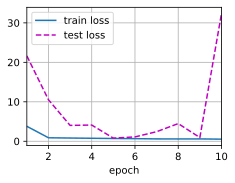

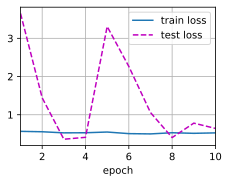

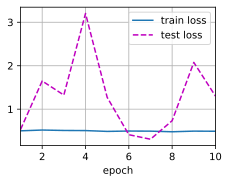

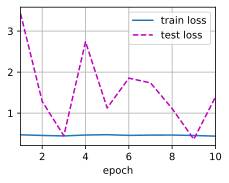

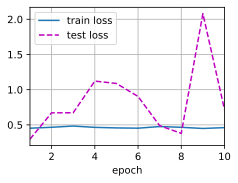

In [14]:
num_epochs, lr = 10, 0.01
dt = datetime.now()
print(f'现在是：{dt.year}年{dt.month}月{dt.day}日 {dt.hour}:{dt.minute}:{dt.second}')

train_rnn_kfold(net, train_iter, 5, lr, num_epochs, try_gpu(), batch_size)
dt = datetime.now()
print(f'现在是：{dt.year}年{dt.month}月{dt.day}日 {dt.hour}:{dt.minute}:{dt.second}')

### GRU train

Fold 1, epoch 10, loss 0.460960, test loss 0.412304, 0.133858 epoch/sec
Fold 2, epoch 10, loss 0.415456, test loss 0.402780, 0.138716 epoch/sec
Fold 3, epoch 10, loss 0.412859, test loss 0.520273, 0.126133 epoch/sec
Fold 4, epoch 10, loss 0.407286, test loss 0.318471, 0.122514 epoch/sec
Fold 5, epoch 10, loss 0.391032, test loss 0.545346, 0.130564 epoch/sec
现在是：2023年12月4日 9:46:35


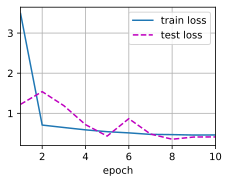

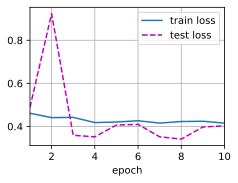

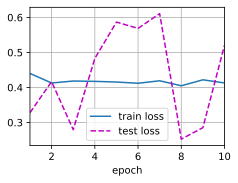

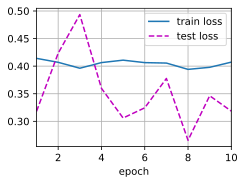

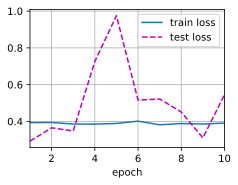

In [15]:
rnn_layer = nn.GRU(len(vocab), num_hiddens, num_layers)
ffn_num_hiddens, linear1_num_hiddens, linear2_num_hiddens, linear3_num_hiddens = 32, 32, 32, 8

net = RNNModel(rnn_layer, len(vocab), ffn_num_hiddens, 
               linear1_num_hiddens, linear2_num_hiddens, linear3_num_hiddens, dropout=0.5)


num_epochs, lr = 10, 0.01
dt = datetime.now()
print(f'现在是：{dt.year}年{dt.month}月{dt.day}日 {dt.hour}:{dt.minute}:{dt.second}')

train_rnn_kfold(net, train_iter, 5, lr, num_epochs, try_gpu(), batch_size)
dt = datetime.now()
print(f'现在是：{dt.year}年{dt.month}月{dt.day}日 {dt.hour}:{dt.minute}:{dt.second}')

### LSTM train

Fold 1, epoch 10, loss 0.501090, test loss 0.733840, 0.091887 epoch/sec
Fold 2, epoch 10, loss 0.427052, test loss 0.394688, 0.063539 epoch/sec
Fold 3, epoch 10, loss 0.437732, test loss 0.400346, 0.088585 epoch/sec
Fold 4, epoch 10, loss 0.388306, test loss 0.563080, 0.140227 epoch/sec
Fold 5, epoch 10, loss 0.379952, test loss 0.420167, 0.131244 epoch/sec
现在是：2023年12月4日 9:55:29


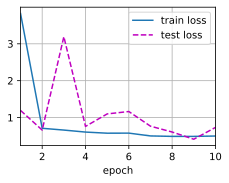

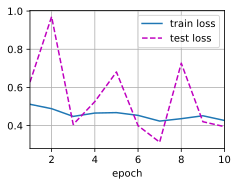

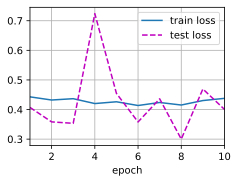

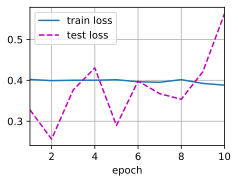

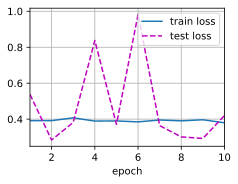

In [16]:
rnn_layer = nn.LSTM(len(vocab), num_hiddens, num_layers)
ffn_num_hiddens, linear1_num_hiddens, linear2_num_hiddens, linear3_num_hiddens = 32, 32, 32, 8

net = RNNModel(rnn_layer, len(vocab), ffn_num_hiddens, 
               linear1_num_hiddens, linear2_num_hiddens, linear3_num_hiddens, dropout=0.5)


num_epochs, lr = 10, 0.01
dt = datetime.now()
print(f'现在是：{dt.year}年{dt.month}月{dt.day}日 {dt.hour}:{dt.minute}:{dt.second}')

train_rnn_kfold(net, train_iter, 5, lr, num_epochs, try_gpu(), batch_size)
dt = datetime.now()
print(f'现在是：{dt.year}年{dt.month}月{dt.day}日 {dt.hour}:{dt.minute}:{dt.second}')

In [50]:
def predict_single(seq, net, vocab, device):
    net.eval()
    state = net.begin_state(batch_size=1, device = device)
    seq = torch.tensor(vocab[[i for i in seq]], device = device).unsqueeze(0)
    # print(seq)
    with torch.no_grad():
        y, _ = net(seq,state)
    return y.squeeze(0).numpy()

In [51]:
# test
predict_single('SLASYLRSM', net, vocab, try_gpu())

array([4.111037], dtype=float32)

## **Save the params**

In [19]:
torch.save(net.state_dict(), './RNN_model.params')
print(f'现在是：{dt.year}年{dt.month}月{dt.day}日 {dt.hour}:{dt.minute}:{dt.second}, 任务已结束。')

现在是：2023年12月4日 9:55:29, 任务已结束。


## **Load the params**

In [20]:
rnn_layer = nn.LSTM(len(vocab), num_hiddens, num_layers)
ffn_num_hiddens, linear1_num_hiddens, linear2_num_hiddens, linear3_num_hiddens = 32, 32, 32, 8

clone = RNNModel(rnn_layer, len(vocab), ffn_num_hiddens, 
               linear1_num_hiddens, linear2_num_hiddens, linear3_num_hiddens, dropout=0.5)
clone.load_state_dict(torch.load('./RNN_model.params'))

<All keys matched successfully>

In [37]:
predict_single('SLASYLRSM', clone, vocab, try_gpu())

array([[4.111037]], dtype=float32)

## **Well Done!**

## **Calculate PearsonR**

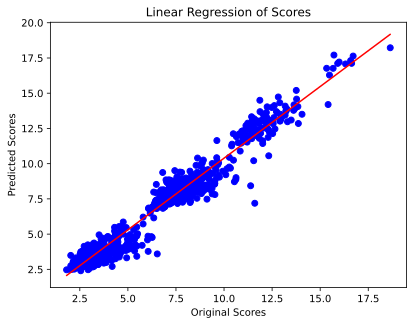

[0.9789736]


In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# Function to read the file and return two lists: scores and peptides
def read_file(filename):
    scores, peptides = [], []
    with open(filename, 'r') as file:
        for line in file:
            parts = line.strip().split()  # Assuming the file is space or tab-delimited
            scores.append(float(parts[0]))
            peptides.append(parts[1])
    return scores, peptides

# Function to calculate the Pearson correlation coefficient
def pearson_coefficient(x, y):
    n = len(x)
    sum_x, sum_y = sum(x), sum(y)
    sum_x2 = sum(xi**2 for xi in x)
    sum_y2 = sum(yi**2 for yi in y)
    sum_xy = sum(xi*yi for xi, yi in zip(x, y))

    numerator = n * sum_xy - sum_x * sum_y
    denominator = ((n * sum_x2 - sum_x**2) * (n * sum_y2 - sum_y**2))**0.5

    if denominator == 0:
        return 0  # Avoid division by zero; correlation is undefined in this case
    
    return numerator / denominator

# Extended calculate_pearson_coefficient function
def calculate_pearson_coefficient(filename, plot_graph=False):
    original_scores, peptides = read_file(filename)
    predicted_scores = [predict_single(peptide, clone, vocab, try_gpu()) for peptide in peptides]
    pearson_coeff = pearson_coefficient(original_scores, predicted_scores)
    
    if plot_graph:
        plot_regression(original_scores, predicted_scores)
    
    return pearson_coeff

# Function to draw a scatter plot with linear regression line
def plot_regression(x, y):
    x = np.array(x).reshape(-1, 1)
    y = np.array(y)

    # Performing linear regression
    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(x)

    # Plotting
    plt.scatter(x, y, color='blue')
    plt.plot(x, y_pred, color='red')
    plt.xlabel('Original Scores')
    plt.ylabel('Predicted Scores')
    plt.title('Linear Regression of Scores')
    plt.show()

# Function to run the entire process
# def calculate_pearson_coefficient(filename):
#     original_scores, peptides = read_file(filename)
#     predicted_scores = [predict_single(peptide, clone, vocab, try_gpu()) for peptide in peptides]
#     return pearson_coefficient(original_scores, predicted_scores)

# Example usage
filename = '../datanet/student_corr_test.txt'
print(calculate_pearson_coefficient(filename, True))
